# AI-Based Trading Strategies

**Author:** J. Francisco Salazar ©

**Date:** 2025-02-15

## LSTM with Attention based Trading Strategy

# End-to-End Data Pipeline

### Import Libraries & Dependencies
We import the necessary libraries for:
- API connection (`requests`)
- Data handling (`pandas`, `numpy`)
- Logging (`logging`)
- Visualization (`matplotlib`)


In [1]:
# --- Standard Libraries ---
import os
import requests
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from time import sleep


## API Configuration
- Load the API Key from environment variables.
- Define the ticker (`GSPC.INDX` for S&P 500).
- Set the date range (`2015-2025`).

In [2]:
# --- API Configuration ---
API_KEY = os.getenv("EODHD_API_KEY")  # Load API Key securely
TICKER = "GSPC.INDX"
START_DATE = "2015-01-01"
END_DATE = "2025-01-01"
BASE_URL = "https://eodhd.com/api/eod/"


## API Request Function 
- Fetches historical data using the **EODHD API**.
- Implements **error handling & retry logic** to manage failed API calls.

In [3]:
def fetch_eod_data(ticker, api_key, start_date, end_date, retries=3, delay=5):
    """
    Fetches historical market data from EODHD API with retry logic.

    Parameters:
    - ticker (str): Stock or index ticker symbol
    - api_key (str): API authentication token
    - start_date (str): Start date for data retrieval
    - end_date (str): End date for data retrieval
    - retries (int): Number of retry attempts in case of failure
    - delay (int): Delay between retries (exponential backoff)

    Returns:
    - pd.DataFrame: Market data if successful, else None
    """
    url = f"{BASE_URL}{ticker}?api_token={api_key}&from={start_date}&to={end_date}&fmt=json"
    
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if data:
                    logging.info(f"Successfully retrieved {len(data)} records.")
                    return pd.DataFrame(data)
                else:
                    logging.warning("API returned an empty dataset.")
            else:
                logging.error(f"API request failed with status {response.status_code}: {response.text}")
        except requests.RequestException as e:
            logging.error(f"API request error: {e}")

        sleep(delay * (2 ** attempt))  # Exponential backoff
    return None
    

## Fetch & Preprocess Data
- Convert `date` column to datetime format.
- Set `date` as index for time-series analysis.
- Convert numeric columns to `float`.
- Handle missing values using **forward-fill**.

In [4]:
df = fetch_eod_data(TICKER, API_KEY, START_DATE, END_DATE)

if df is not None:
    
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    df.set_index("date", inplace=True)

    numeric_cols = ["open", "high", "low", "close", "adjusted_close", "volume"]
    df[numeric_cols] = df[numeric_cols].astype(float)

    df.ffill(inplace=True)  

    display(df.head())
    

,open,high,low,close,adjusted_close,volume
date,,,,,,
2015-01-02,2058.8999,2072.3601,2046.0400,2058.2000,2058.2000,2.708700e+09
2015-01-05,2054.4399,2054.4399,2017.3400,2020.5800,2020.5800,3.799120e+09
2015-01-06,2022.1500,2030.2500,1992.4399,2002.6100,2002.6100,4.460110e+09
2015-01-07,2005.5500,2029.6100,2005.5500,2025.9000,2025.9000,3.805480e+09
2015-01-08,2030.6100,2064.0801,2030.6100,2062.1399,2062.1399,3.934010e+09


In [5]:
# --- Check Data Completeness ---
print("\n Data Overview:")
print(df.info())  # Check structure & missing values
print("\n Missing Values Summary:")
print(df.isna().sum())  # Count missing values per column



🔍 Data Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            2516 non-null   float64
 1   high            2516 non-null   float64
 2   low             2516 non-null   float64
 3   close           2516 non-null   float64
 4   adjusted_close  2516 non-null   float64
 5   volume          2516 non-null   float64
dtypes: float64(6)
memory usage: 137.6 KB
None

🔍 Missing Values Summary:
open              0
high              0
low               0
close             0
adjusted_close    0
volume            0
dtype: int64


## Data Visualization
- **Figure 1:** **S&P 500 adjusted closing prices** over time.

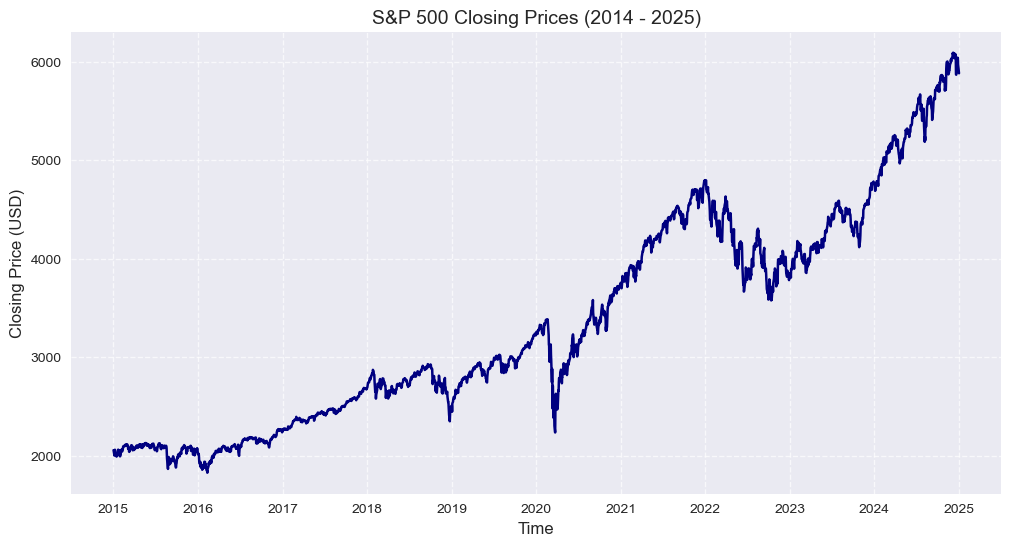

In [6]:
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("Figure 1: S&P 500 Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()


## Feature Engineering & Transformation

In [7]:
# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

### Volatility-Adjusted Returns:

In [8]:
# Rolling Volatility (10-day)
df["volatility_10"] = df["log_returns"].rolling(10).std()

# Volatility-Adjusted Returns
df["vol_adj_returns"] = df["log_returns"] / df["volatility_10"]

df.dropna(inplace=True)

df.head()


,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns
date,,,,,,,,,
2015-01-16,1992.2500,2020.4600,1988.12,2019.4200,2019.4200,4.056410e+09,0.013335,0.011898,1.120778
2015-01-20,2020.7600,2028.9399,2004.49,2022.5500,2022.5500,3.944340e+09,0.001549,0.010393,0.149011
2015-01-21,2020.1899,2038.2900,2012.04,2032.1200,2032.1200,3.730070e+09,0.004720,0.009963,0.473790
2015-01-22,2034.3000,2064.6201,2026.38,2063.1499,2063.1499,4.176050e+09,0.015154,0.010422,1.454073
2015-01-23,2062.9800,2062.9800,2050.54,2051.8201,2051.8201,3.573560e+09,-0.005507,0.008970,-0.613873


### Technical Indicators  

**Table 1:**

LSTM models **learn patterns from sequences**, so we should select indicators that enhance **trend detection, volatility awareness, and momentum signals**.

| **Category**              | **Indicator**                                      | **Best Periods** | **Why Useful?**                                   |
|---------------------------|---------------------------------------------------|----------------|--------------------------------------------------|
| **Moving Averages**        | **EMA (Exponential Moving Avg)**                 | **EMA(50, 200)** | Captures recent trend changes faster           |
| **Momentum Indicators**    | **RSI (Relative Strength Index)**                | **RSI(14)** | Identifies momentum & overbought/oversold conditions   |
| **Momentum Indicators**    | **MACD (Moving Avg Convergence Divergence)**     | **MACD(12,26,9)** | Detects momentum shifts & trend reversals   |
| **Volatility Indicators**  | **ATR (Average True Range)**                     | **ATR(14)** | Measures market volatility & stop-loss adjustments        |
| **Trend Indicators**       | **SAR (Parabolic SAR)**                          | **SAR(Default)** | Tracks trend direction & reversals                        |
| **Trend Indicators**       | **SLOPE (Slope Indicator)**                      | **SLOPE(14)** | Confirms trend strength                        |
| **Trend Indicators**       | **ADX (Average Directional Index)**              | **ADX(14)** | Measures trend strength without direction |
| **Volume Indicators**      | **OBV (On-Balance Volume)**                      | **OBV(Default)** | Confirms trend strength via volume              |


In [9]:
# Momentum Indicators: RSI & MACD
def compute_rsi(df, column="adjusted_close", period=14):
    delta = df[column].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = np.convolve(gain, np.ones(period)/period, mode='same')
    avg_loss = np.convolve(loss, np.ones(period)/period, mode='same')
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(df, column="adjusted_close", short_period=12, long_period=26, signal_period=9):
    short_ema = df[column].ewm(span=short_period, adjust=False).mean()
    long_ema = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Moving Averages: EMA 50 & EMA 200
def compute_ema(df, column="adjusted_close", period=50):
    return df[column].ewm(span=period, adjust=False).mean()

def compute_ema_200(df, column="adjusted_close", period=200):
    return df[column].ewm(span=period, adjust=False).mean()

# Volatility Indicator: ATR
def compute_atr(df, period=14):
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    return tr.rolling(window=period).mean()

# Trend Indicators: SAR, Slope & ADX
def compute_slope(df, column="adjusted_close", period=14):
    return df[column].diff(period) / period

def compute_sar(df, acceleration=0.02, maximum=0.2):
    sar = np.zeros(len(df))
    trend = 1  # Assume first trend is bullish
    extreme_point = df["high"].iloc[0]
    af = acceleration
    
    for i in range(1, len(df)):
        sar[i] = sar[i - 1] + af * (extreme_point - sar[i - 1]) if trend == 1 else sar[i - 1] - af * (sar[i - 1] - extreme_point)
        extreme_point = max(extreme_point, df["high"].iloc[i]) if trend == 1 else min(extreme_point, df["low"].iloc[i])
        af = min(af + acceleration, maximum)
    return sar

def compute_adx(df, period=14):
    plus_dm = np.maximum(df["high"].diff(), 0)
    minus_dm = np.maximum(-df["low"].diff(), 0)
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

# Volume Indicator: OBV
def compute_obv_vectorized(df):
    direction = np.sign(df["adjusted_close"].diff()).fillna(0)
    return (direction * df["volume"]).cumsum()


# Compute Indicators and Add to DataFrame
df["EMA_50"] = compute_ema(df, period=50)
df["EMA_200"] = compute_ema_200(df, period=200)
df["RSI_14"] = compute_rsi(df, period=14)
df["MACD"], df["MACD_Signal"] = compute_macd(df)
df["ATR_14"] = compute_atr(df, period=14)
df["SAR"] = compute_sar(df)
df["SLOPE_14"] = compute_slope(df, period=14)
df["ADX_14"] = compute_adx(df, period=14)
df["OBV"] = compute_obv_vectorized(df)

# Fill any NaNs from rolling calculations
df.fillna(0, inplace=True)


In [10]:
df.tail()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,EMA_200,RSI_14,MACD,MACD_Signal,ATR_14,SAR,SLOPE_14,ADX_14,OBV
date,,,,,,,,,,,,,,,,,,,
2024-12-24,5984.6299,6040.1001,5981.4399,6040.0400,6040.0400,1.757720e+09,0.010982,0.012074,0.909572,5925.960009,5544.409080,34.896357,9.407257,24.168665,63.848636,6096.839858,-3.317871,39.597659,5.880851e+11
2024-12-26,6024.9702,6049.7500,6007.3701,6037.5898,6037.5898,2.904530e+09,-0.000406,0.011739,-0.034564,5930.337648,5549.316351,34.906316,12.219770,21.778886,65.329350,6097.465926,-2.680007,39.552855,5.851806e+11
2024-12-27,6006.1699,6006.1699,5932.9502,5970.8398,5970.8398,3.159610e+09,-0.011117,0.012121,-0.917157,5931.925968,5553.510614,32.126586,8.959262,19.214961,71.027871,6097.966781,-8.530729,36.486945,5.820210e+11
2024-12-30,5920.6699,5940.7900,5869.1602,5906.9399,5906.9399,3.433250e+09,-0.010760,0.012463,-0.863339,5930.946122,5557.027324,33.590982,1.205206,15.613010,75.316407,6098.367465,-10.422157,35.279184,5.785877e+11
2024-12-31,5919.7402,5929.7402,5868.8599,5881.6299,5881.6299,3.128350e+09,-0.004294,0.012277,-0.349771,5929.012153,5560.257200,51.407296,-6.902675,11.109873,77.128586,6098.688012,-10.948593,34.491337,5.754594e+11


### Adding Lag Features (`lag_1` to `lag_7`) 

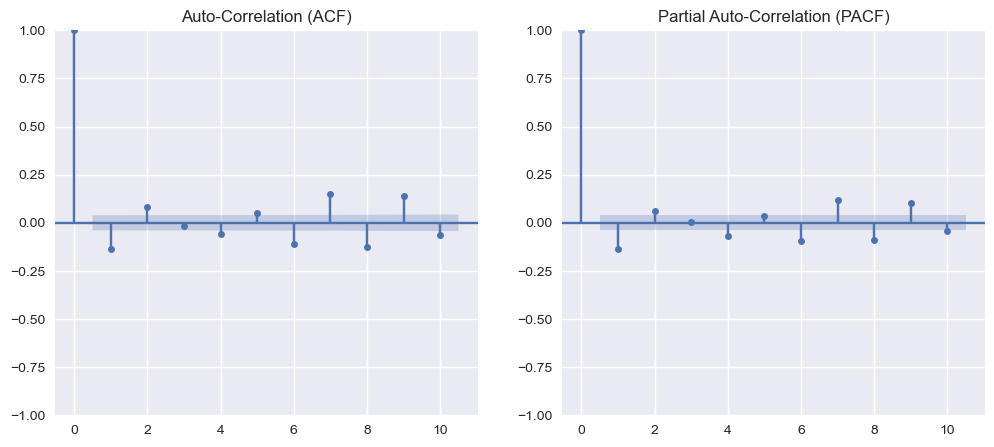


✅ Updated DataFrame Structure After Selecting Significant Lags:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-26 to 2024-12-31
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2501 non-null   float64
 1   high             2501 non-null   float64
 2   low              2501 non-null   float64
 3   close            2501 non-null   float64
 4   adjusted_close   2501 non-null   float64
 5   volume           2501 non-null   float64
 6   log_returns      2501 non-null   float64
 7   volatility_10    2501 non-null   float64
 8   vol_adj_returns  2501 non-null   float64
 9   EMA_50           2501 non-null   float64
 10  EMA_200          2501 non-null   float64
 11  RSI_14           2501 non-null   float64
 12  MACD             2501 non-null   float64
 13  MACD_Signal      2501 non-null   float64
 14  ATR_14           2501 non-null   float64
 15  SAR              2501 n

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#  Step 1: Plot ACF & PACF BEFORE adding lag features
plt.figure(figsize=(12, 5))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(df["log_returns"].dropna(), lags=10, ax=plt.gca())
plt.title("Auto-Correlation (ACF)")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df["log_returns"].dropna(), lags=10, ax=plt.gca())
plt.title("Partial Auto-Correlation (PACF)")

plt.show()

#  Step 2: Select significant lags based on ACF/PACF analysis
selected_lags = [1, 3, 5]  # Adjust based on the actual ACF/PACF plot

#  Step 3: Generate only the selected lags
for lag in selected_lags:
    df[f'lag_{lag}'] = df['log_returns'].shift(lag)

#  Step 4: Drop NaN values caused by shifting
df.dropna(inplace=True)

#  Step 5: Check DataFrame structure after adding optimized lag features
print("\n Updated DataFrame Structure After Selecting Significant Lags:")
print(df.info())


### Feature Correlation Matrix 

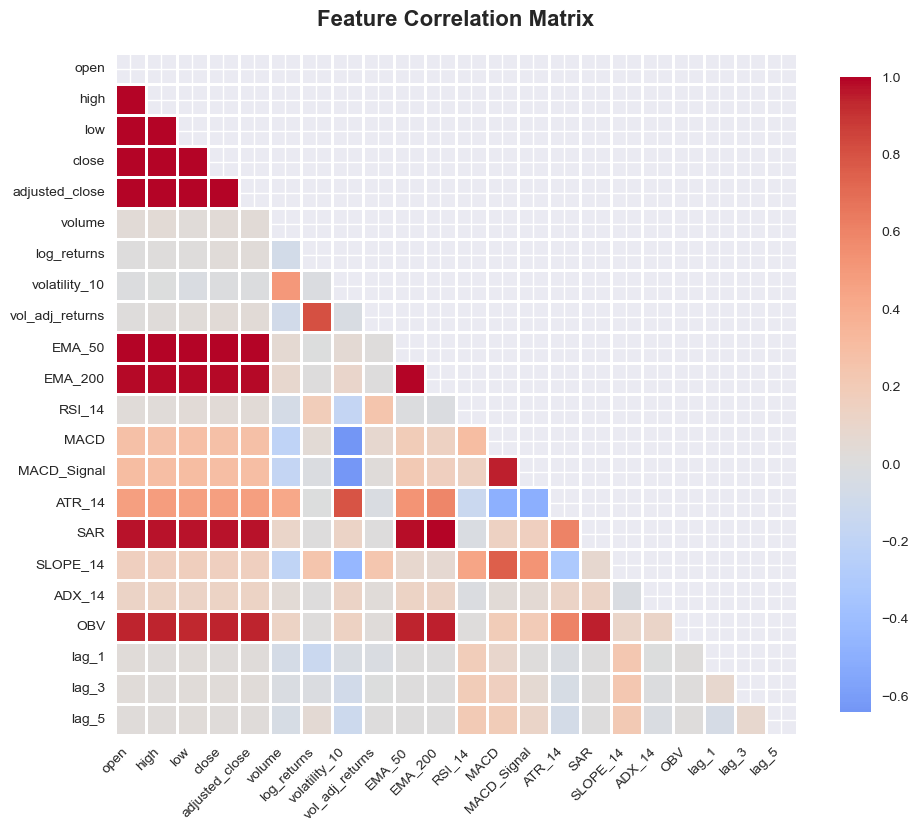


 **Dropped Highly Correlated Features:**
['SAR', 'EMA_200', 'low', 'close', 'high', 'EMA_50', 'MACD_Signal', 'OBV', 'adjusted_close']

 **Updated DataFrame Structure After Correlation Filtering:**
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-26 to 2024-12-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2501 non-null   float64
 1   volume           2501 non-null   float64
 2   log_returns      2501 non-null   float64
 3   volatility_10    2501 non-null   float64
 4   vol_adj_returns  2501 non-null   float64
 5   RSI_14           2501 non-null   float64
 6   MACD             2501 non-null   float64
 7   ATR_14           2501 non-null   float64
 8   SLOPE_14         2501 non-null   float64
 9   ADX_14           2501 non-null   float64
 10  lag_1            2501 non-null   float64
 11  lag_3            2501 non-null   float64
 12  lag_5            2501 non-nu

In [12]:
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Generate a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dynamic figure sizing
n_features = corr_matrix.shape[0]
plt.figure(figsize=(n_features * 0.5, n_features * 0.5))  

sns.heatmap(
    corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=1, cbar_kws={"shrink": 0.75}, square=True
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight='bold', pad=20)

plt.show()

# -------------- Feature Selection Based on Correlation --------------
# Lower the correlation threshold to catch more redundant features
threshold = 0.85  # Previously 0.9, now more aggressive

# Identify highly correlated features
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Drop highly correlated features
df.drop(columns=high_corr_features, inplace=True)

# Display the dropped features
print("\n Dropped Highly Correlated Features:")
print(f"{list(high_corr_features) if high_corr_features else 'None'}")

# Show updated DataFrame info
print("\n Updated DataFrame Structure After Correlation Filtering:")
print(df.info())


### Definition of Target Variable (`d`)

In [13]:
# --- Define Target Variable (`d`) ---
df['d'] = np.where(df['log_returns'].shift(-1) > 0, 1, 0)

# Drop only NaN values in 'd' caused by shifting (Last row)
df.dropna(subset=['d'], inplace=True)

# --- Corrected Feature Selection (X) ---
X = df[[col for col in [
     'open', 'volume', 'log_returns', 'volatility_10', 'vol_adj_returns',
    'RSI_14', 'MACD', 'ATR_14', 'SLOPE_14', 'ADX_14', 
    'lag_1', 'lag_3', 'lag_5'
] if col in df.columns]]  # Only include columns that exist

# --- Define Target Variable (y) ---
y = df['d']

# Verify Structure
print("Feature Matrix (X) Shape:", X.shape)
print("Target Variable (y) Shape:", y.shape)
display(df.tail())

print(df['d'].value_counts(normalize=True))


Feature Matrix (X) Shape: (2501, 13)
Target Variable (y) Shape: (2501,)


,open,volume,log_returns,volatility_10,vol_adj_returns,RSI_14,MACD,ATR_14,SLOPE_14,ADX_14,lag_1,lag_3,lag_5,d
date,,,,,,,,,,,,,,
2024-12-24,5984.6299,1.757720e+09,0.010982,0.012074,0.909572,34.896357,9.407257,63.848636,-3.317871,39.597659,0.007261,-0.000865,-0.003871,0
2024-12-26,6024.9702,2.904530e+09,-0.000406,0.011739,-0.034564,34.906316,12.219770,65.329350,-2.680007,39.552855,0.010982,0.010810,-0.029937,0
2024-12-27,6006.1699,3.159610e+09,-0.011117,0.012121,-0.917157,32.126586,8.959262,71.027871,-8.530729,36.486945,-0.000406,0.007261,-0.000865,0
2024-12-30,5920.6699,3.433250e+09,-0.010760,0.012463,-0.863339,33.590982,1.205206,75.316407,-10.422157,35.279184,-0.011117,0.010982,0.010810,0
2024-12-31,5919.7402,3.128350e+09,-0.004294,0.012277,-0.349771,51.407296,-6.902675,77.128586,-10.948593,34.491337,-0.010760,-0.000406,0.007261,0


1    0.537385
0    0.462615
Name: d, dtype: float64


### Feature Selection Using `ExtraTreesClassifier`

Training set shape: (1748, 13), (1748,)
Test set shape: (753, 13), (753,)


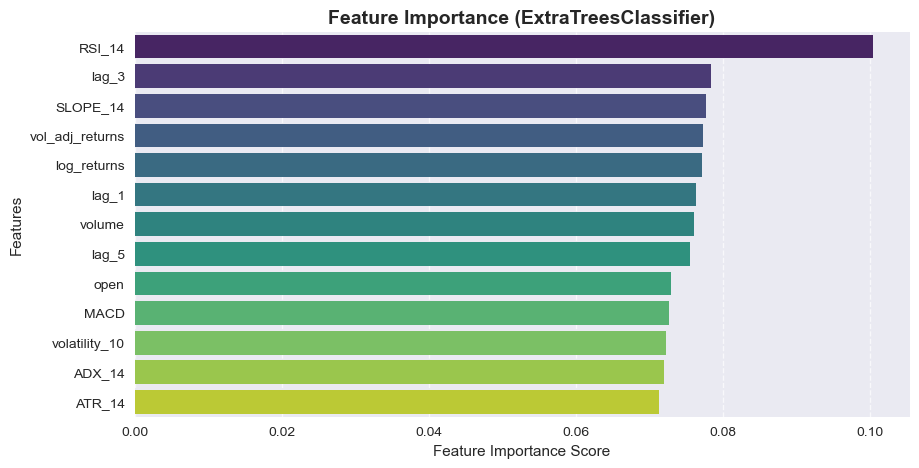


 Top 13 Features (Training Set):
['RSI_14', 'lag_3', 'SLOPE_14', 'vol_adj_returns', 'log_returns', 'lag_1', 'volume', 'lag_5', 'open', 'MACD', 'volatility_10', 'ADX_14', 'ATR_14']

 Final Feature Set After Selection:
X_train_selected shape: (1748, 13)
X_test_selected shape: (753, 13)


In [14]:
from sklearn.ensemble import ExtraTreesClassifier

#  Step 1: Define a chronological cutoff date for train/test split
train_cutoff = '2022-01-01'  # Modify if needed

df_train = df.loc[:train_cutoff]
df_test = df.loc[train_cutoff:]

X_train = X.loc[df_train.index]
y_train = y.loc[df_train.index]
X_test = X.loc[df_test.index]
y_test = y.loc[df_test.index]

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

#  Step 2: Fit ExtraTreesClassifier ONLY on training set
model_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
model_fs.fit(X_train, y_train)

#  Step 3: Extract feature importances
feature_importance = pd.Series(
    model_fs.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

#  Step 4: Plot feature importances
plt.figure(figsize=(10, 5))
sns.barplot(
    x=feature_importance.values, 
    y=feature_importance.index, 
    hue=feature_importance.index,  # Explicitly set hue to y variable
    palette="viridis",
    dodge=False,
    legend=False  # Prevent duplicate legend
)
plt.title("Feature Importance (ExtraTreesClassifier)", fontsize=14, fontweight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#  Step 5: Select top N features
n_top = min(15, len(feature_importance))  # Ensure it does not exceed available features
top_features = feature_importance.index[:n_top]

print(f"\n Top {n_top} Features (Training Set):")
print(top_features.tolist())

#  Step 6: Apply selected features to both train & test sets
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print("\n Final Feature Set After Selection:")
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")


### Preparation of `X` and `y` for LSTM Model

In [15]:
from sklearn.preprocessing import StandardScaler


##############################
# Step 1: Standardize Training Data Only
##############################
scaler = StandardScaler()
scaler.fit(X_train_selected)  # Fit only on training data

X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)  # Use same scaler on test set

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_selected.index, columns=X_train_selected.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_selected.index, columns=X_test_selected.columns)

print("\n **Standardization Completed:** Data is now scaled.")

##############################
# Step 2: Create Sequences for LSTM
##############################
def create_sequences(X_df, y_series, seq_length=7):
    """
    Generates sequences from a DataFrame (X_df) and aligns with the target (y_series).
    Returns (X_seq, y_seq).
    """
    X_values = X_df.values  
    y_values = y_series.values  

    # For each valid starting index i, create a sequence: [i : i + seq_length]
    X_seq = np.array([
        X_values[i : i + seq_length] 
        for i in range(len(X_values) - seq_length)
    ])
    # The label for that sequence is y at index i + seq_length
    y_seq = y_values[seq_length:]  

    return X_seq, y_seq

sequence_length = 7  # Set sequence length

# Safety checks before sequence creation
if len(X_train_scaled) < sequence_length:
    raise ValueError(" Not enough training data to generate sequences! Adjust `sequence_length` or dataset size.")
if len(X_test_scaled) < sequence_length:
    raise ValueError(" Not enough test data to generate sequences! Adjust `sequence_length` or dataset size.")

# Generate training & test sequences
X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train, seq_length=sequence_length)
X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test, seq_length=sequence_length)

##############################
# Step 3: Confirm Shapes
##############################
print("\n Final Sequence Shapes for LSTM Training:")
print(f"X_seq_train: {X_seq_train.shape} (Samples={X_seq_train.shape[0]}, Time Steps={sequence_length}, Features={X_seq_train.shape[2]})")
print(f"y_seq_train: {y_seq_train.shape} (Samples={y_seq_train.shape[0]})")
print(f"X_seq_test:  {X_seq_test.shape} (Samples={X_seq_test.shape[0]}, Time Steps={sequence_length}, Features={X_seq_test.shape[2]})")
print(f"y_seq_test:  {y_seq_test.shape} (Samples={y_seq_test.shape[0]})")



✅ **Standardization Completed:** Data is now scaled.

✅ **Final Sequence Shapes for LSTM Training:**
X_seq_train: (1741, 7, 13) (Samples=1741, Time Steps=7, Features=13)
y_seq_train: (1741,) (Samples=1741)
X_seq_test:  (746, 7, 13) (Samples=746, Time Steps=7, Features=13)
y_seq_test:  (746,) (Samples=746)


# Model Implementation & Training
## Model Definition & Initialization

#### LSTM with Attention Architecture

In [16]:
import os

# Suppress TensorFlow logging (set to '0' for full logging, '1' for errors only)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Disable verbose Metal plugin messages (for Apple M1/M2/M3)
os.environ['METAL_DEVICE_WRAPPER_SUPPRESS'] = '1'


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply
from tensorflow.keras.optimizers.legacy import Adam  #0 Fix for M1/M2 Macs

##############################
# Step 1: Define Attention Layer
##############################
def attention_layer(inputs):
    """
    Implements a simple attention mechanism.
    Args:
        inputs: LSTM output sequence (batch_size, time_steps, units)
    Returns:
        context_vector: Weighted sum of the LSTM outputs (batch_size, units)
        attention_weights: Weights computed for each time step
    """
    # Compute attention scores for each time step
    attention_scores = Dense(1, activation='tanh', name="attention_scores")(inputs)  # (batch_size, time_steps, 1)
    attention_scores = tf.squeeze(attention_scores, axis=-1)  # (batch_size, time_steps)

    # Convert scores to attention weights via softmax
    attention_weights = tf.nn.softmax(attention_scores, axis=1, name="attention_weights")  # (batch_size, time_steps)

    # Compute the context vector as a weighted sum of the LSTM outputs
    context_vector = Multiply(name="weighted_sum")([inputs, tf.expand_dims(attention_weights, axis=-1)])  # (batch_size, time_steps, units)
    context_vector = tf.reduce_sum(context_vector, axis=1, name="context_vector")  # (batch_size, units)

    return context_vector, attention_weights

##############################
# Step 2: Define LSTM Model with Attention
##############################
def get_attention_model(input_shape, lstm_units=80, dropout_rate=0.1, lr=2.6293879057284552e-05):
    """
    Builds an LSTM model with an attention mechanism.
    Args:
        input_shape: Tuple representing (time_steps, features)
        lstm_units: Number of units in the LSTM layer
        dropout_rate: Dropout rate for regularization
        lr: Learning rate for the optimizer
    Returns:
        model: Compiled Keras model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape, name="input_layer")

    # LSTM layer that returns sequences for attention
    lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_layer")(inputs)
    lstm_output = Dropout(dropout_rate, name="dropout_layer")(lstm_output)

    # Apply attention mechanism on LSTM outputs
    context_vector, attention_weights = attention_layer(lstm_output)

    # Final Dense output layer for binary classification
    outputs = Dense(1, activation='sigmoid', name="output_layer")(context_vector)

    # Define and compile the model
    model = Model(inputs, outputs, name="LSTM_Attention_Model")
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    # Display model summary
    model.summary()

    return model

##############################
# Step 3: Instantiate & Compile Model
##############################
# Define input shape based on training sequences
input_shape = (X_seq_train.shape[1], X_seq_train.shape[2])  # (time_steps, features)

# Instantiate model
attention_model = get_attention_model(input_shape)


Model: "LSTM_Attention_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 7, 13)]              0         []                            
                                                                                                  
 lstm_layer (LSTM)           (None, 7, 80)                30080     ['input_layer[0][0]']         
                                                                                                  
 dropout_layer (Dropout)     (None, 7, 80)                0         ['lstm_layer[0][0]']          
                                                                                                  
 attention_scores (Dense)    (None, 7, 1)                 81        ['dropout_layer[0][0]']       
                                                                               

## Model Training with Rolling Cross-Validation
### Training Implementation

* Rolling Time-Series Cross-Validation → Ensures robust evaluation.
* Scaling within each fold → Prevents data leakage.
* Early Stopping → Stops training if validation loss stops improving.
* Standard Metrics → Accuracy, Precision, Recall, F1-Score

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assume the new attention_layer and get_attention_model functions are defined as above

# ----------------------------------------
# Define a function to create the LSTM with Attention model
# ----------------------------------------
def get_attention_model(input_shape, lstm_units=80, dropout_rate=0.1, lr=2.6293879057284552e-05):
    # [Function definition from above]
    inputs = Input(shape=input_shape)
    lstm_output = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_output = Dropout(dropout_rate)(lstm_output)
    context_vector, _ = attention_layer(lstm_output)
    outputs = Dense(1, activation='sigmoid')(context_vector)
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

# ----------------------------------------
# Time-Series Cross-Validation Setup on Training Sequences Only
# ----------------------------------------
# Assume X_seq_train and y_seq_train are already defined appropriately

tscv = TimeSeriesSplit(n_splits=6, test_size=252)

predictions, true_labels = [], []
fold_metrics = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq_train)):
    print(f"\nProcessing Fold {fold + 1}/{tscv.n_splits}...")
    
    X_train_fold = X_seq_train[train_index]
    X_test_fold = X_seq_train[test_index]
    y_train_fold = y_seq_train[train_index]
    y_test_fold = y_seq_train[test_index]
    
    nsamples_train, timesteps, n_features = X_train_fold.shape
    X_train_fold_2d = X_train_fold.reshape(-1, n_features)
    
    scaler = StandardScaler()
    scaler.fit(X_train_fold_2d)
    X_train_fold_scaled = scaler.transform(X_train_fold_2d).reshape(X_train_fold.shape)
    
    X_test_fold_2d = X_test_fold.reshape(-1, n_features)
    X_test_fold_scaled = scaler.transform(X_test_fold_2d).reshape(X_test_fold.shape)
    
    # -----------------------------
    # Build and train the attention model for this fold
    # -----------------------------
    model = get_attention_model((timesteps, n_features))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train_fold_scaled, y_train_fold,
              validation_data=(X_test_fold_scaled, y_test_fold),
              epochs=50, batch_size=128,
              verbose=0, callbacks=[early_stopping])
    
    pred = model.predict(X_test_fold_scaled).flatten()
    pred_binary = [1 if p >= 0.5 else 0 for p in pred]
    
    predictions.extend(pred)
    true_labels.extend(y_test_fold)
    
    fold_accuracy = accuracy_score(y_test_fold, pred_binary)
    fold_precision = precision_score(y_test_fold, pred_binary)
    fold_recall = recall_score(y_test_fold, pred_binary)
    fold_f1 = f1_score(y_test_fold, pred_binary)
    
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": fold_accuracy,
        "precision": fold_precision,
        "recall": fold_recall,
        "f1_score": fold_f1
    })

df_fold_metrics = pd.DataFrame(fold_metrics)
df_fold_metrics.to_csv("fold_metrics.csv", index=False)
print("\nFold Metrics:")
display(df_fold_metrics)

predictions_binary = [1 if p >= 0.5 else 0 for p in predictions]
overall_accuracy = accuracy_score(true_labels, predictions_binary)
overall_precision = precision_score(true_labels, predictions_binary)
overall_recall = recall_score(true_labels, predictions_binary)
overall_f1 = f1_score(true_labels, predictions_binary)

print("\nCross-Validated Model Performance (Training Set):")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1-score: {overall_f1:.4f}")

print("\nMean Fold Performance:")
print(df_fold_metrics[["accuracy", "precision", "recall", "f1_score"]].mean())



Processing Fold 1/6...
8/8 [==============================] - 0s 6ms/step

Processing Fold 2/6...
8/8 [==============================] - 0s 6ms/step

Processing Fold 3/6...
8/8 [==============================] - 0s 6ms/step

Processing Fold 4/6...
8/8 [==============================] - 0s 7ms/step

Processing Fold 5/6...
8/8 [==============================] - 0s 7ms/step

Processing Fold 6/6...
8/8 [==============================] - 0s 8ms/step

Fold Metrics:


,fold,accuracy,precision,recall,f1_score
0,1,0.599206,0.605634,0.656489,0.630037
1,2,0.464286,0.576271,0.236111,0.334975
2,3,0.559524,0.585366,0.545455,0.564706
3,4,0.603175,0.609649,0.926667,0.735450
4,5,0.587302,0.580645,1.000000,0.734694
5,6,0.567460,0.569721,0.993056,0.724051



Cross-Validated Model Performance (Training Set):
Accuracy: 0.5635
Precision: 0.5880
Recall: 0.7314
F1-score: 0.6519

Mean Fold Performance:
accuracy     0.563492
precision    0.587881
recall       0.726296
f1_score     0.620652
dtype: float64


#### `Saving & Logging`

In [18]:
import shutil 

# Save the best model from cross-validation
model.save("best_att_lstm_model.keras")

# Backup in case of overwriting
shutil.copy("best_att_lstm_model.keras", "best_att_lstm_model_backup.keras")

'best_att_lstm_model_backup.keras'

**Up to this section, we have put together a production-grade pipeline for a state-of-the-art DL-based trading strategy.**  

# Trading Signal Generation and Backtesting Module

In [19]:
def run_backtest(
    df, predictions, 
    transaction_cost=0.0001, 
    long_threshold=0.505, 
    short_threshold=0.495, 
    min_hold_days=3,
    stop_loss_threshold=-0.025,  # Stop-loss: Exit if daily loss > -2.5%
    rolling_loss_threshold=-0.05,  # Exit if rolling 10-day return < -5%
    volatility_scaling=True
):
    """
    Backtests a trading strategy with:
    - Lowered probability thresholds for better trade execution.
    - Adaptive holding period (exit when probability confidence weakens).
    - Stop-loss mechanism to prevent major drawdowns.
    - Volatility-based position scaling.
    
    Parameters:
        df (DataFrame): Historical price data including 'log_returns'.
        predictions (array-like): Model output probabilities for the test period.
        transaction_cost (float): Cost per trade.
        long_threshold (float): Minimum probability to enter a long trade.
        short_threshold (float): Maximum probability to enter a short trade.
        min_hold_days (int): Minimum days to hold a position once taken.
        stop_loss_threshold (float): Stop-loss exit threshold per trade.
        rolling_loss_threshold (float): Exit if rolling 10-day loss > threshold.
        volatility_scaling (bool): If True, position size scales based on volatility.

    Returns:
        df_backtest (DataFrame): DataFrame with backtest results including an equity curve.
    """
    df_backtest = df.copy()
    
    # Align predictions with the last len(predictions) rows of df_backtest
    df_backtest['p'] = np.nan
    df_backtest.loc[df_backtest.index[-len(predictions):], 'p'] = predictions

    # Generate raw trading signals based on adjusted thresholds
    df_backtest['raw_signal'] = np.select(
        [df_backtest['p'] >= long_threshold, df_backtest['p'] <= short_threshold],
        [1, -1], default=0
    )

    # ---------------------------
    # Adaptive Holding Period
    # ---------------------------
    raw_signals = df_backtest['raw_signal']
    final_positions = []
    current_position = 0
    hold_counter = 0

    for i in range(len(raw_signals)):
        if hold_counter > 0:
            # Continue holding the position
            final_positions.append(current_position)
            hold_counter -= 1
        else:
            # Allow new signal entry
            if raw_signals.iloc[i] != 0:
                current_position = raw_signals.iloc[i]
                hold_counter = min_hold_days - 1  # Hold for at least min_hold_days
                final_positions.append(current_position)
            else:
                # Exit if probability confidence weakens
                current_position = 0
                final_positions.append(0)

    df_backtest['po'] = final_positions
    df_backtest['po_shifted'] = df_backtest['po'].shift(1).fillna(0)  # Avoid look-ahead bias

    # ---------------------------
    # Stop-Loss Implementation
    # ---------------------------
    df_backtest['daily_return'] = df_backtest['po_shifted'] * df_backtest['log_returns']
    
    # Apply stop-loss: Exit position if loss exceeds stop_loss_threshold
    stop_loss_exit = df_backtest['daily_return'] <= stop_loss_threshold
    df_backtest.loc[stop_loss_exit, 'po_shifted'] = 0

    # Apply rolling 10-day loss exit condition
    df_backtest['rolling_loss'] = df_backtest['daily_return'].rolling(10).sum()
    df_backtest.loc[df_backtest['rolling_loss'] <= rolling_loss_threshold, 'po_shifted'] = 0

    # ---------------------------
    # Volatility-Based Position Sizing
    # ---------------------------
    if volatility_scaling:
        df_backtest['volatility_30d'] = df_backtest['log_returns'].rolling(30).std()
        avg_volatility = df_backtest['volatility_30d'].mean()
        df_backtest['position_size'] = df_backtest['po_shifted'] * (avg_volatility / df_backtest['volatility_30d'])
    else:
        df_backtest['position_size'] = df_backtest['po_shifted']

    # ---------------------------
    # Compute Strategy Returns
    # ---------------------------
    df_backtest['strategy_log_return'] = df_backtest['position_size'] * df_backtest['log_returns']

    # ---------------------------
    # Apply Transaction Costs
    # ---------------------------
    df_backtest['trade_cost'] = transaction_cost * df_backtest['po'].diff().abs().fillna(0)
    df_backtest['strategy_net_log_return'] = df_backtest['strategy_log_return'] - df_backtest['trade_cost']

    # ---------------------------
    # Compute Equity Curve
    # ---------------------------
    df_backtest['equity_curve'] = np.exp(df_backtest['strategy_net_log_return'].cumsum())

    return df_backtest

#  Run the backtest
df_backtest = run_backtest(df, predictions)

#  Print results
print(df_backtest[['log_returns', 'p', 'po', 'strategy_log_return', 'trade_cost', 'strategy_net_log_return', 'equity_curve']].tail())



            log_returns         p  po  strategy_log_return  trade_cost  \
date                                                                     
2024-12-24     0.010982  0.632166   1             0.013291         0.0   
2024-12-26    -0.000406  0.649032   1            -0.000492         0.0   
2024-12-27    -0.011117  0.629945   1            -0.013037         0.0   
2024-12-30    -0.010760  0.630740   1            -0.012369         0.0   
2024-12-31    -0.004294  0.618332   1            -0.005143         0.0   

            strategy_net_log_return  equity_curve  
date                                               
2024-12-24                 0.013291      3.332389  
2024-12-26                -0.000492      3.330749  
2024-12-27                -0.013037      3.287607  
2024-12-30                -0.012369      3.247193  
2024-12-31                -0.005143      3.230534  


# AI Strategy Performance Review

## Plot 1: Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

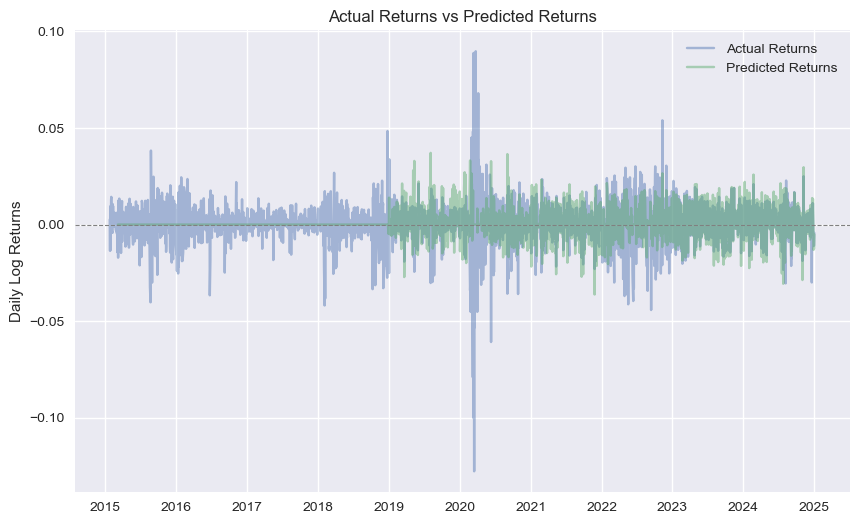

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['log_returns'], label="Actual Returns", alpha=0.45)
plt.plot(df_backtest.index, df_backtest['strategy_log_return'], label="Predicted Returns", alpha=0.45)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Predicted Returns")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()


## Plot 2: Equity Curve of the Strategy
Show the cumulative performance over time.

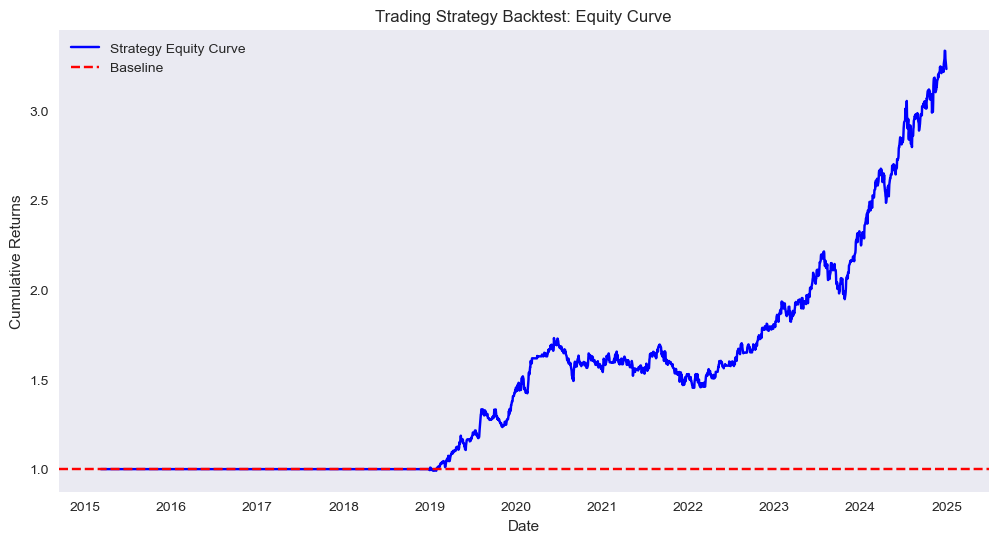

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df_backtest.index, df_backtest['equity_curve'], label="Strategy Equity Curve", color='blue')
plt.axhline(1.0, linestyle='--', color='red', label="Baseline")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Strategy Backtest: Equity Curve")
plt.legend()
plt.grid()
plt.show()


## Plot 3: Strategy vs. Benchmark Comparison
Illustrate whether the strategy outperforms a simple buy-and-hold benchmark.

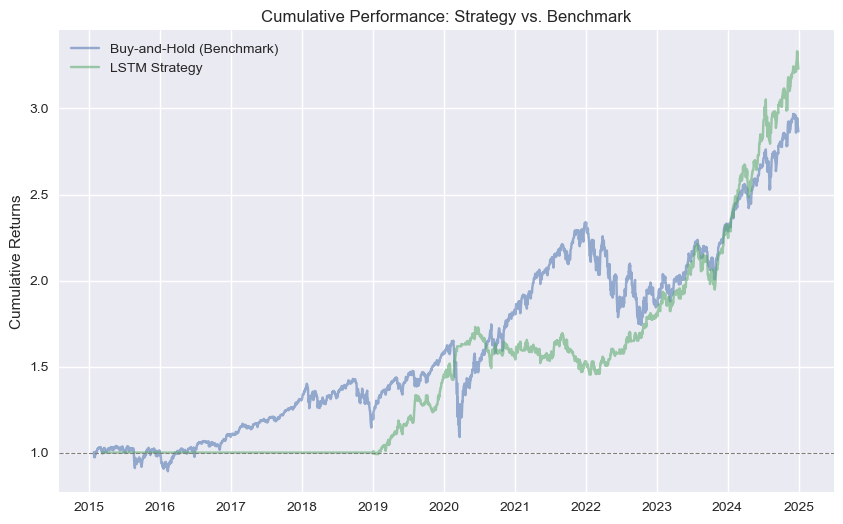

In [22]:
# Convert log returns to cumulative returns for buy-and-hold:
df_backtest['buy_and_hold'] = np.exp(df_backtest['log_returns'].cumsum())
df_backtest['cumulative_strategy'] = df_backtest['equity_curve']

plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['buy_and_hold'], label="Buy-and-Hold (Benchmark)", alpha=0.55)
plt.plot(df_backtest.index, df_backtest['cumulative_strategy'], label="LSTM Strategy", alpha=0.55)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.title("Cumulative Performance: Strategy vs. Benchmark")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


## `quantstats` Analytics Module


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2018-12-28   2018-12-28
End Period          2024-12-31   2024-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       92.0%

Cumulative Return   136.32%      223.05%
CAGR﹪              10.38%       14.41%

Sharpe              0.81         1.47
Prob. Sharpe Ratio  97.48%       99.99%
Sortino             1.14         2.3
Sortino/√2          0.81         1.63
Omega               1.29         1.29

Max Drawdown        -33.92%      -16.0%
Longest DD Days     745          865

Gain/Pain Ratio     0.17         0.29
Gain/Pain (1M)      0.95         2.06

Payoff Ratio        1.17         1.23
Profit Factor       1.17         1.29
Common Sense Ratio  1.1          1.46
CPC Index           0.75         0.81
Tail Ratio          0.94         1.13
Outlier Win Ratio   3.24         4.01
Outlier Loss Ratio  3.25         4.41

MTD                 -2.5%        0.76%
3M            

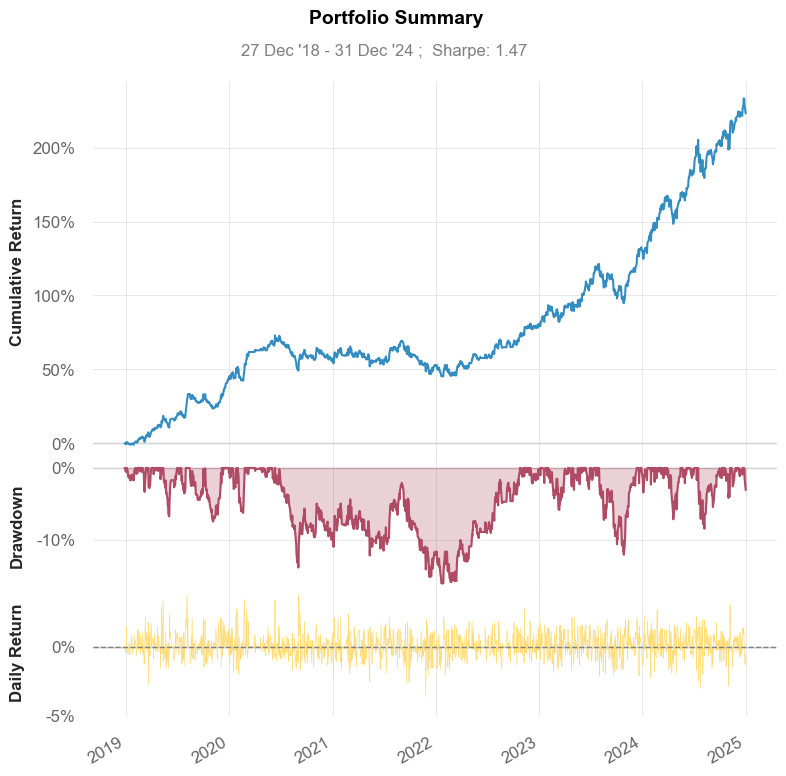

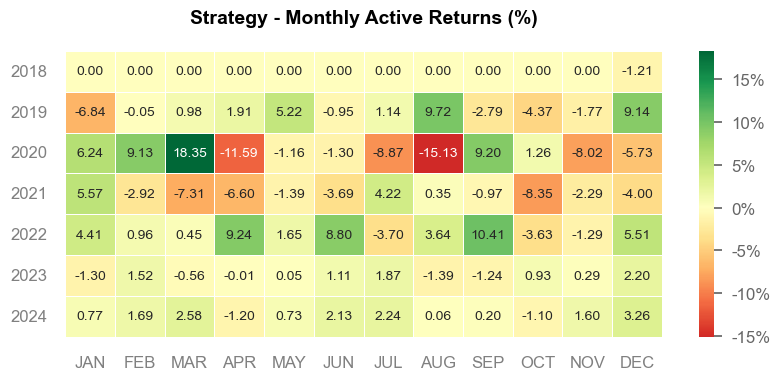

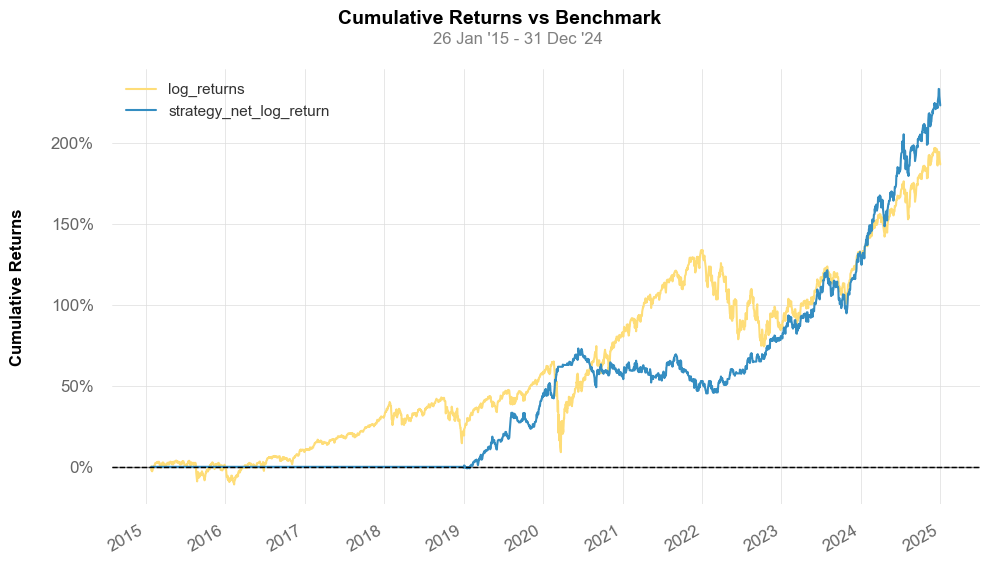

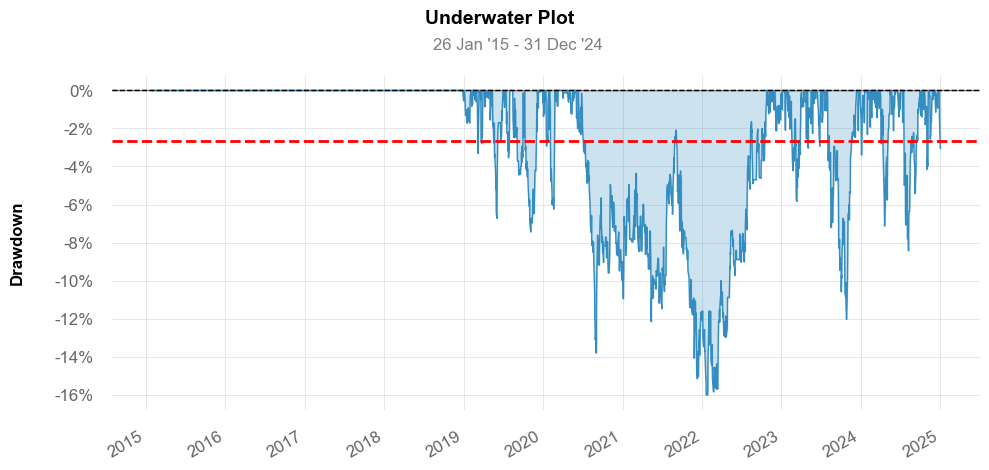

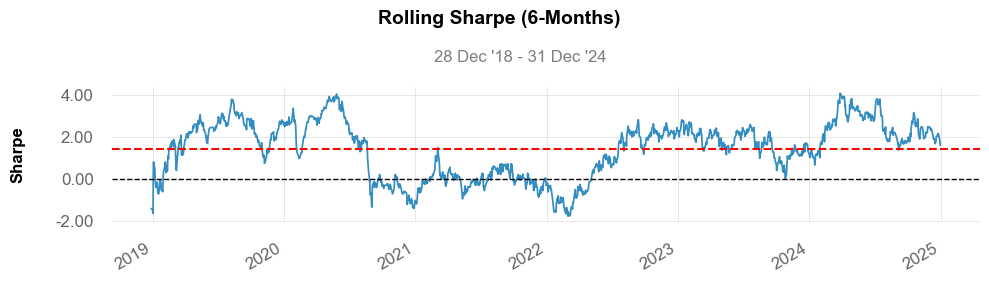

In [23]:
# Convert net log returns to simple daily returns:
strategy_simple_returns = np.exp(df_backtest['strategy_net_log_return']) - 1
benchmark_simple_returns = np.exp(df_backtest['log_returns']) - 1

import quantstats as qs

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)
